# Dark Triad Classification Project Proposal

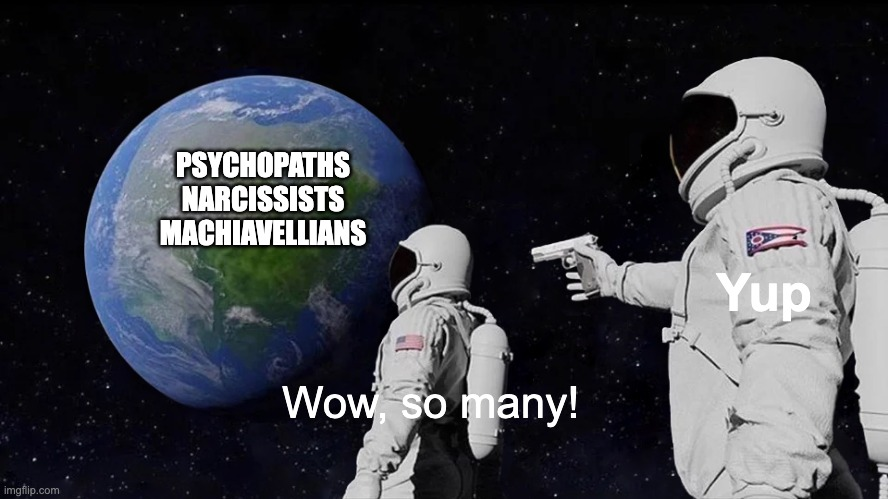

## PROJECT OVERVIEW
---

### What is the dark triad?

The dark triad is a term used to describe the collection of three psychological traits: **psychopathy**, **narcissism**, and **machiavellianism**. Though there tends to be overlap in the behaviors of people possessing one or more of these traits, they are all recognized as separate traits. 

(The following defines each trait; if you are familiar, feel free to skip to the next section.)

**Psychopathy** is a personality disorder characterized by enduring patterns of antisocial behavior, shallow affect, lack of empathy or remorse, manipulation, and a disregard for societal norms and the rights of others.

**Narcissism** is a personality trait or disorder characterized by an inflated sense of self-importance, excessive admiration and preoccupation with oneself, a lack of empathy for others, and a strong desire for attention and admiration from others. Individuals with narcissistic traits often have an exaggerated sense of their own abilities, a need for constant validation and admiration, and a tendency to exploit and manipulate others to meet their own needs. 

**Machiavellianism** is a personality trait or strategy characterized by cunning, manipulation, and a willingness to use deceit and manipulation to achieve personal goals.

### Overview of the Datasets
---

**DATASET 1** contains 18,192 rows and 29 columns. There are 28 columns that are possible features (the 29th column indicates the source of the data and is not relevant). 27 of these contain information about respondents answers to the 27 questions that make up the *Short Measure of the Dark Triad* questionnaire, a psychological evaluation exam created in 2011 to provide a quick assessment of a person's relative scores for each of the three dark triad traits.

**DATASET 2** contains 53,981 rows and 26 columns. There are 22 columns that refer to respondents answers to the *Hyper Sensitive Narcissism Scale* (HSNS: 10 questions) and the *Dirty Dozen* (DD: 12 questions) psychological assessments for dark triad traits. The remaining 4 columns contain information regarding respondents' ages, gender, country of origin, and most interestingly, the percentage of the questions that the respondents' claim to have answered honestly.

### Goal of the Project
---

#### Primary Goal

- Develop mutli-class classification models that predict one of the triad traits based on the other two for each dataset (a total of 6 final models; presumably many more models would be tested).

#### Additional Goals

- Acquire additional dark triad trait assessment datasets to look for clusters of behaviors/traits that are not traditionally recognized as associated with dark triad traits.
- Create user-interface that allows for users to take one or more of the aforementioned assessments (they are publicly available and easily evaluated) and compare their actual scores to the predicted ones. The sort of comparison would depend on whether the dataset(s) are sufficiently large to allow for a powerful enough regression model to be trained; early testing does not give much hope for this, making a classification model more likely to be used.


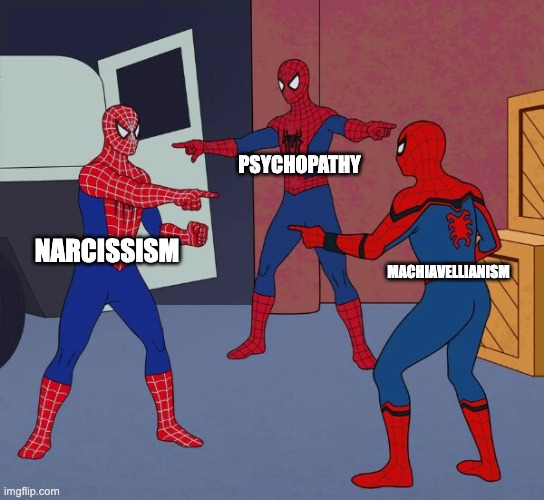

# Exploratory Analysis of the First Dataset

In [5]:
# Importing all packages used for the remaineder of the code
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, \
                             AdaBoostRegressor, GradientBoostingRegressor, \
                             VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [11]:
# The dataset is currently being stored locally. 
# It is available at: https://www.kaggle.com/datasets/yamqwe/short-dark-triad
dark_triad_df = pd.read_csv('Data/archive (6)/data.csv', delimiter = '\t')

## Preprocessing

In [12]:
# Shape of the dataframe
dark_triad_df.shape

(18192, 29)

In [13]:
# First three rows of the dataframe
dark_triad_df.head(3)

,M1,M2,M3,M4,M5,M6,M7,M8,M9,N1,...,P2,P3,P4,P5,P6,P7,P8,P9,country,source
0,4,4,4,4,4,4,4,3,4,2,...,4,3,2,4,4,4,4,4,GB,1
1,2,1,5,2,2,1,2,2,3,1,...,1,1,5,4,1,5,3,2,US,1
2,3,3,3,5,1,1,5,5,3,2,...,5,3,1,3,1,2,3,1,US,1


In [18]:
# Checking the number of observations per country
dark_triad_df['country'].value_counts()

US    9252
GB    2810
CA    1213
AU     760
FI     274
      ... 
MZ       1
DZ       1
LR       1
GY       1
OM       1
Name: country, Length: 142, dtype: int64

In [19]:
# Checking what proportion of the countries have at least 5 observations
sum(dark_triad_df['country'].value_counts() >= 5) / len(dark_triad_df['country'].unique())

0.5874125874125874

During the actual project development, I would give more consideration to how to best handle the country column. For now, I will just drop it. I will also drop the source column since it only indicates how the data was collected.

In [20]:
# Dropping source column
dark_triad_df.drop(columns = ['source', 'country'], inplace = True)
dark_triad_df.shape

(18192, 27)

In [27]:
# Creating a new dataframe of average scores
question_scores = pd.DataFrame(dark_triad_df.mean(axis = 0), columns= ['Scores']). \
                               sort_values(by = 'Scores', ascending = False). \
                               reset_index()

# Showing 5 questions with highest average score and 5 with the lowest
# Five highest average score questions dictionary (ordered highest to lowest)
five_highest = {'M7': 'There are things you should hide from other people because they don\'t need to know.',
                'M1': 'It\'s not wise to tell your secrets.',
                'M9': 'Most people can be manipulated.',
                'P5': 'It\'s true that I can be mean to others.',
                'M6': 'You should wait for the right time to get back at people.'}

# Five lowest average score questions dictionary (ordered lowest to highest)
five_lowest = {'P4': 'People often say Im out of control.',
               'P8': 'I enjoy having sex with people I hardly know',
               'N8': 'I am an average person.',
               'P3': 'Payback needs to be quick and nasty.',
               'N3': 'Many group activities tend to be dull without me.'}

In [39]:
print("Five Highest Scoring Questions\n")
for i in five_highest.values():
    print(i)
    
print("")
print("Five Lowest Scoring Questions\n")
for i in five_lowest.values():
    print(i)

Five Highest Scoring Questions

There are things you should hide from other people because they don't need to know.
It's not wise to tell your secrets.
Most people can be manipulated.
It's true that I can be mean to others.
You should wait for the right time to get back at people.

Five Lowest Scoring Questions

People often say Im out of control.
I enjoy having sex with people I hardly know
I am an average person.
Payback needs to be quick and nasty.
Many group activities tend to be dull without me.


In [28]:
# Creating a list of to which of the triad members each question belongs
triad_class = []

for ind in question_scores['index']:
    if 'M' in ind:
        triad_class.append('Machiavellianism')
    elif 'N' in ind:
        triad_class.append('Narcissism')
    else:
        triad_class.append('Psychopathy')

# Adding the list to the question_scores dataframe
question_scores['Triad Member'] = triad_class

In [41]:
# Plotly barplot
plt.figure(figsize = (15, 8));
fig = px.bar(question_scores, x = 'index', y = 'Scores', text_auto='.2s',
       title = 'Average Score by Question',
       labels = {'index': 'Questions',
                 'Scores': 'Average Score'},
       color = 'Triad Member');
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'});
fig.show();

<Figure size 1500x800 with 0 Axes>

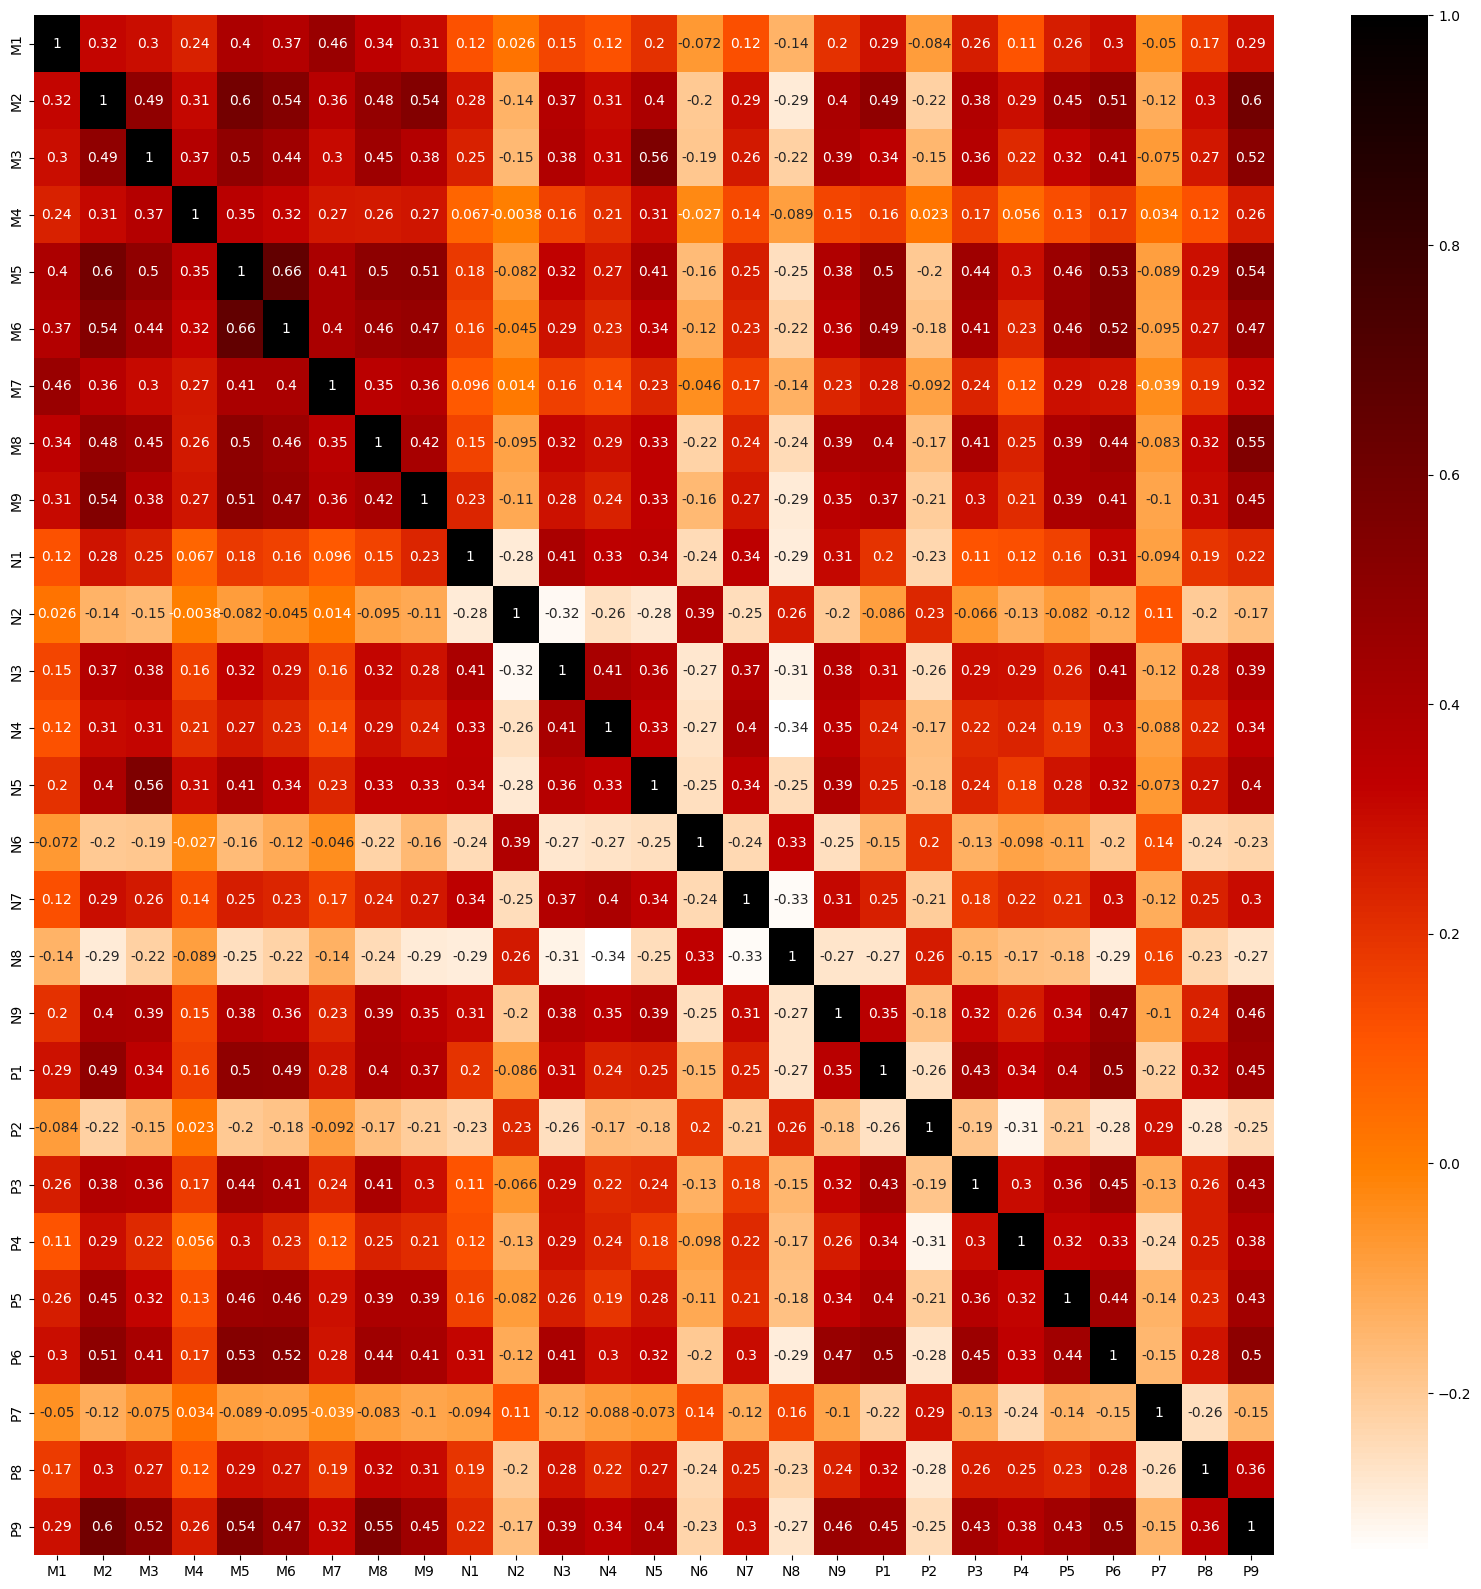

In [42]:
# Correlation Heatmap 
plt.figure(figsize = (20,20))
sns.heatmap(data = dark_triad_df.corr(), cmap = 'gist_heat_r', annot = True);
plt.show()

In [43]:
# Separating out the questions by triad class
narcis_questions = [f'N{int(i)}' for i in np.linspace(1, 9, 9)]
psych_questions = [f'P{int(i)}' for i in np.linspace(1, 9, 9)]
mach_questions = [f'M{int(i)}' for i in np.linspace(1, 9, 9)]

# Making 3 dataframes; each is missing either narcissism, psychopathy, or machievellianism questions

# Not narcissism questions dataframe
not_narcis_df = pd.DataFrame()

for i in dark_triad_df.columns:
    if i not in narcis_questions:
        not_narcis_df[f'{i}'] = dark_triad_df[i]
        
# Not psychopathy questions dataframe
not_psych_df = pd.DataFrame()

for i in dark_triad_df.columns:
    if i not in psych_questions:
        not_psych_df[f'{i}'] = dark_triad_df[i]
        
# Not Machievellianism questions dataframe
not_mach_df = pd.DataFrame()

for i in dark_triad_df.columns:
    if i not in mach_questions:
        not_mach_df[f'{i}'] = dark_triad_df[i]

In [48]:
# Computing average scores by question type per row.

# Lists of average scores
narcis_df = dark_triad_df[['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9']]
mach_df = dark_triad_df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']]
psych_df = dark_triad_df[['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']]

# Dataframe of the average score by category per person
triad_class_scores = pd.DataFrame({
    'narcissism_score': narcis_df.mean(axis = 1).round(3),
    'psychopathy_score': psych_df.mean(axis = 1).round(3),
    'machievellianism_score': mach_df.mean(axis = 1).round(3)
})

# Adding overall average score column to triad_class_score dataframe
tmp = triad_class_scores.mean(axis = 1)
triad_class_scores['Overall Average Score'] = tmp
triad_class_scores.head(3)

,narcissism_score,psychopathy_score,machievellianism_score,Overall Average Score
0,3.111,3.556,3.889,3.518667
1,2.889,2.556,2.222,2.555667
2,2.889,2.444,3.222,2.851667


<AxesSubplot:>

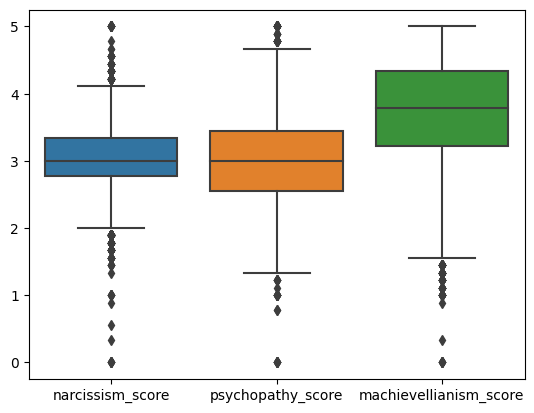

In [49]:
# Boxplot to see distribution of scores by category
sns.boxplot(data = triad_class_scores.iloc[:, :-1])

## Model Development

I have not yet dealt with scaling, encoding, or otherwise preparing the dataset to optimize it for modeling. All of the models performances shown here are just to get a (very) loose idea of what sort of performance might be achieved during proper development.

All of the models are also untuned beyond their automatic settings and have not been cross-validated.

### Regression Models

In [51]:
# Setting up the features and target
X = not_narcis_df
y = triad_class_scores['narcissism_score']

# Creating training and testing sets
# Note: I will always use random_state 137 for consistency in testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 137)

# Linear Regression
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
linreg_model.score(X_test, y_test)  # approximately 29.09% 

# KNN
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test) # approx. 18.75%

# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test) # approx. 27.5%

# Bagging
bag_model = BaggingRegressor()
bag_model.fit(X_train, y_train)
bag_model.score(X_test, y_test) # approx. 19.3%

# GradientBoosting
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_model.score(X_test, y_test) # approx. 30.16%

# XGB
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train); # approx. 22%

In [65]:
# Comparing the scores
tmp = {'Linear Regression': round(linreg_model.score(X_test, y_test),3),
             'KNN': round(knn_model.score(X_test, y_test),3),
             'Random Forests': round(rf_model.score(X_test, y_test),3),
             'Bagging': round(bag_model.score(X_test, y_test),3),
             'Gradient Boosting': round(gb_model.score(X_test, y_test),3),
             'XGBoost': round(xgb_model.score(X_test, y_test),3)}

for key, value in tmp.items():
    print(f'{key} score is {value}')

Linear Regression score is 0.295
KNN score is 0.182
Random Forests score is 0.273
Bagging score is 0.196
Gradient Boosting score is 0.305
XGBoost score is 0.238


These are very low R-squared scores. While they might rise with proper preprocessing and model tuning, I am skeptical about their performance improving to the point of being usable in any practical context. So, I will focus on classification models instead.

Since the modeling process would (probably) be very similar across each triad member, I am only including models that classify narcissism.

In [66]:
### Classification Models for predicting narcissism
y_rounded = triad_class_scores['narcissism_score']

# Classifying each element as one of 4 classes
y_rounded = y_rounded.apply(round)

# Resplitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_rounded, test_size = 0.3, random_state = 137)

In [68]:
# Logistic Classifier
# Instantiating the model
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 10000)

# Fitting the model
logreg_model.fit(X_train, y_train)

# KNN Classifier
# Instantiating the model
knn_classifier_model = KNeighborsClassifier()

# Fitting the model
knn_classifier_model.fit(X_train, y_train);

In [69]:
# Showing the scores
logreg_model.score(X_test, y_test), knn_classifier_model.score(X_test, y_test)

(0.7462440454378894, 0.7150971051667278)

These are reasonably high accuracies (which would need to be compared to a baseline and evaluated alongside other metrics), which gives me confidence in planning to use classifiers as the primary modeling method for the first dataset.

# Dataset 2

Given that the first dataset is relatively small (and I am not presently sure how models will perform post-proper preprocessing and tuning), I am also including a second dataset that uses a different but related criteria.

In [71]:
# Reading in the dataset (availabl at: https://www.kaggle.com/datasets/yamqwe/hypersensitive-narcissism-dirty-dozen)
dt2_df = pd.read_csv('Data/HSNS+DD/data.csv', delimiter = '\t')

# Looking at the table
dt2_df.head(3)

,HSNS1,HSNS2,HSNS3,HSNS4,HSNS5,HSNS6,HSNS7,HSNS8,HSNS9,HSNS10,...,DDN3,DDN4,DDM1,DDM2,DDM3,DDM4,age,gender,accuracy,country
0,2,4,5,1,4,5,4,3,3,2,...,1,1,1,2,2,1,37,2,98,PT
1,4,2,2,4,3,4,4,5,4,3,...,2,3,4,4,4,3,34,3,95,PL
2,5,5,5,4,2,5,5,4,4,2,...,4,3,3,4,4,2,22,2,80,AU


In [72]:
# Looking at table shape
dt2_df.shape

(53981, 26)

In [73]:
# Dropping the columns with accuracy over 100
dt2_df = dt2_df[dt2_df.accuracy <= 100]

# Segmenting the dataset into HSNS and DD questions

# HSNS dataframe
hsns_df = dt2_df.iloc[:, 0:10]

# DD dataframe
dd_df = dt2_df.iloc[:, 10:22]

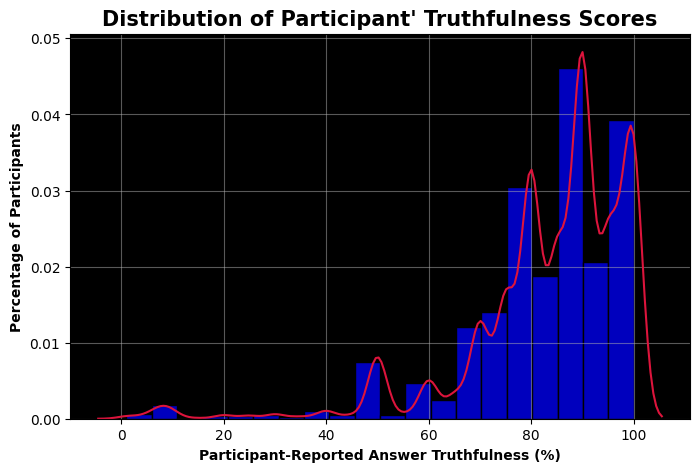

In [74]:
plt.figure(figsize = (8, 5))
ax = sns.histplot(data=dt2_df, x="accuracy", kde=False, stat='density', bins = 20, color = 'blue')
sns.kdeplot(data=dt2_df, x="accuracy", color='crimson', ax = ax)
plt.xlabel('Participant-Reported Answer Truthfulness (%)', weight = 'bold', size = 10)
plt.ylabel('Percentage of Participants', weight = 'bold', size = 10)
plt.title('Distribution of Participant\' Truthfulness Scores', weight = 'bold', size = 15)
ax.set_facecolor('black')
plt.grid(alpha = 0.5)

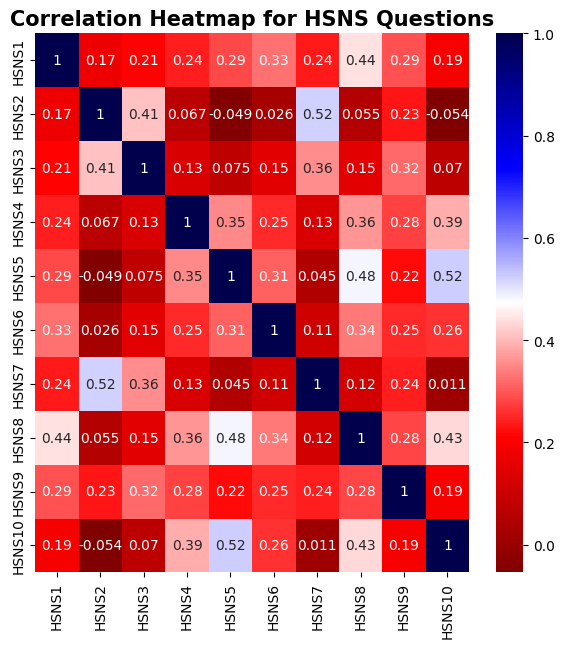

In [75]:
# Correlation Heatmap for HSNS questions
plt.figure(figsize = (7,7))
sns.heatmap(data = hsns_df.corr(), cmap = 'seismic_r', annot = True);
plt.title('Correlation Heatmap for HSNS Questions', weight = 'bold', size = 15)
plt.show()

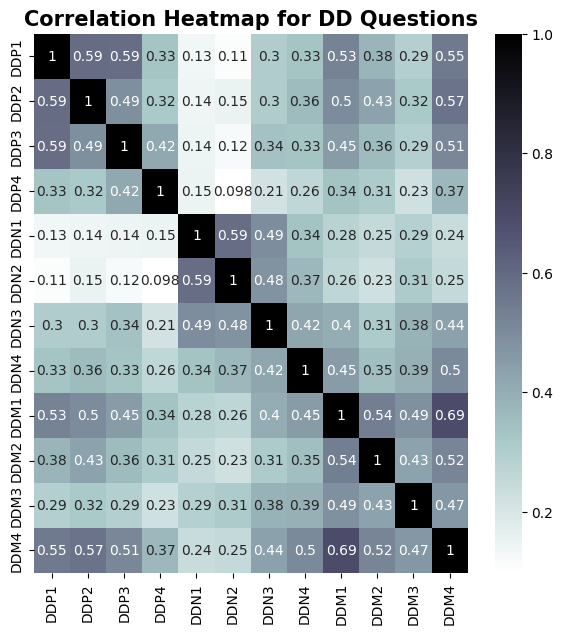

In [76]:
# Correlation Heatmap for DD questions
plt.figure(figsize = (7,7))
sns.heatmap(data = dd_df.corr(), cmap = 'bone_r', annot = True);
plt.title('Correlation Heatmap for DD Questions', weight = 'bold', size = 15)
plt.show()

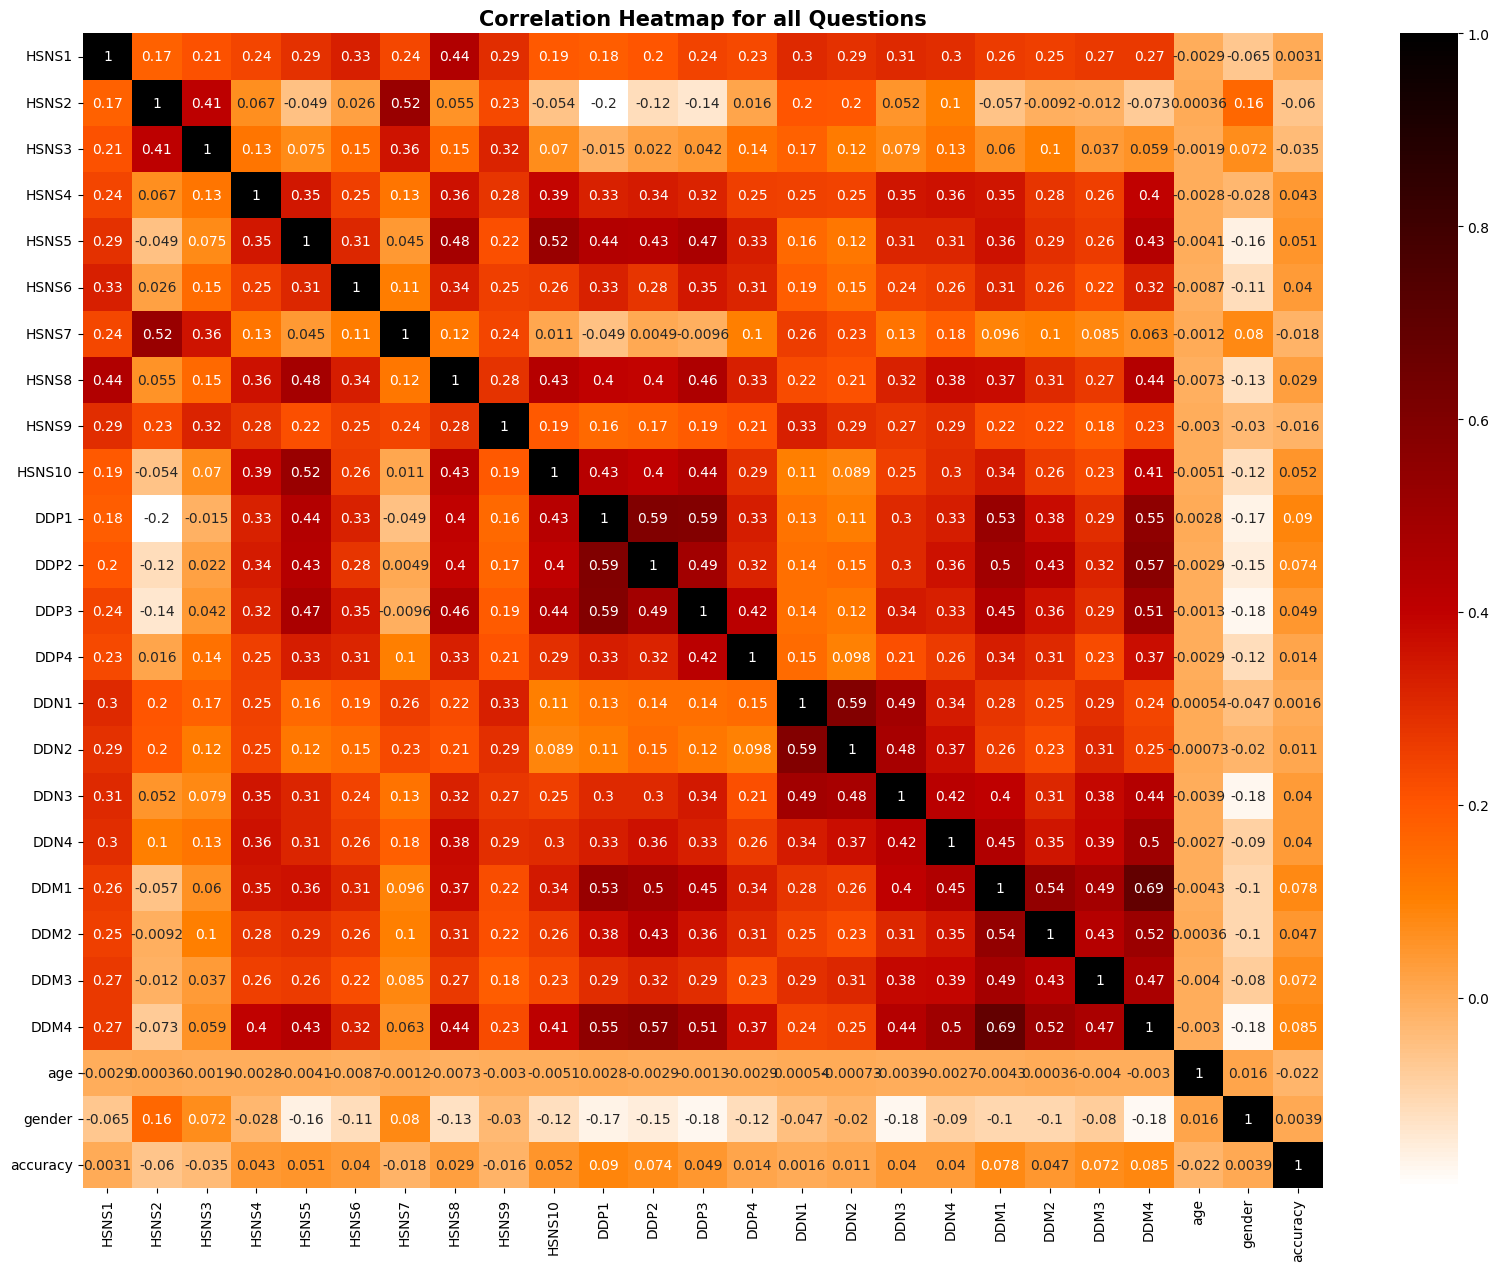

In [82]:
# Correlation map of entire dataset
plt.figure(figsize = (20,15))
sns.heatmap(data = dt2_df.corr(), cmap = 'gist_heat_r', annot = True);
plt.title('Correlation Heatmap for all Questions', weight = 'bold', size = 15)
plt.show()